# Dataset Information
* Dataset: Apple Stock Price Dataset from Kaggle

* Source: https://www.kaggle.com/datasets/prasoonkottarathil/apple-lifetime-stocks-dataset

* Description: Historical Apple stock prices with OHLC (Open, High, Low, Close) data from 1980-2021

* Format: CSV with columns: Date, Open, High, Low, Close, Adj Close, Volume

* Size: 10,000+ daily records, perfect for time series learning

* Alternative: Any stock dataset from Yahoo Finance or similar

# Part1: Dataset Preparation and Exploration


## Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Load and Explore the Time Series Data

In [3]:
# TODO 1.1.1: Load the dataset
# Download from: https://www.kaggle.com/datasets/prasoonkottarathil/apple-lifetime-stocks-dataset
df = pd.read_csv('AAPL.csv')

# TODO 1.1.2: Explore the dataset structure
print("Dataset shape:", df.shape)

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

# TODO 1.1.3: Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# TODO 1.1.4: Display basic statistics
print("\nDataset statistics:")
print(df.describe())

# TODO 1.1.5: Check date range
print(f"\nDate range: {df.index.min().date()} to {df.index.max().date()} ")


Dataset shape: (9823, 7)

First 5 rows:
         Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.407747  117258400.0
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.386473   43971200.0
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.358108   26432000.0
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366972   21610400.0
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.377609   18362400.0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: flo

## Visualize Time Series Patterns

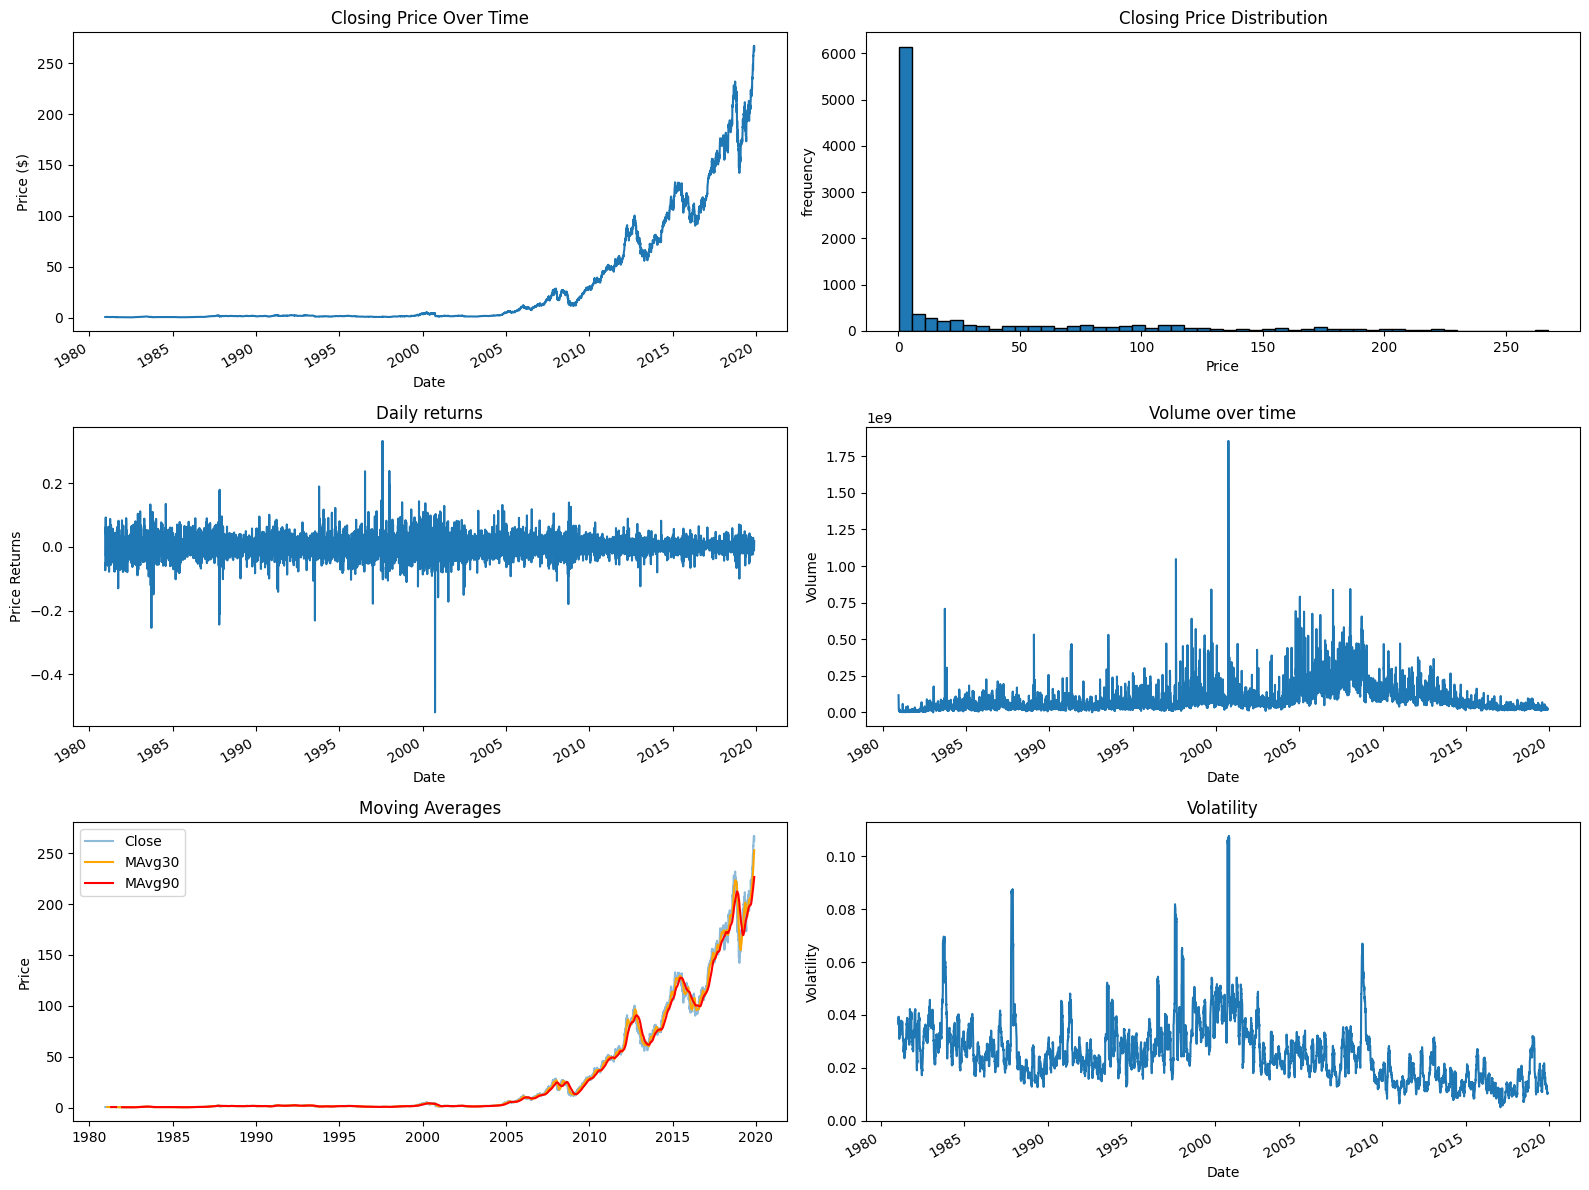

Summary Statistics:
Average closing price: $30.35
Price volatility (std): $53.46
Min price: $0.20
Max price: $267.10


In [4]:
def plot_time_series_exploration(df):
    """
    Creating comprehensive visualizations of the time series data

    TODO 1.2.1: Implement time series visualization
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))

    # TODO 1.2.2: Plot closing price over time
    # Use axes[0,0] for the main time series plot
    df['Close'].plot(ax=axes[0, 0], title='Closing Price Over Time')
    axes[0, 0].set_ylabel('Price ($)')

    # TODO 1.2.3: Plot price distribution histogram
    # Use axes[0,1] for closing price distribution
    axes[0,1].hist(df['Close'], bins = 50, edgecolor = 'black')
    axes[0,1].set_title('Closing Price Distribution')
    axes[0,1].set_xlabel('Price')
    axes[0,1].set_ylabel('frequency')

    # TODO 1.2.4: Plot daily returns
    # Plot using axes[1,0]
    daily_returns = df['Close'].pct_change()
    daily_returns.plot(ax=axes[1,0], title='Daily returns')
    axes[1,0].set_ylabel('Price Returns')

    # TODO 1.2.5: Plot volume over time
    # Use axes[1,1] for volume analysis
    df['Volume'].plot(ax=axes[1,1], title='Volume over time')
    axes[1,1].set_ylabel('Volume')

    # TODO 1.2.6: Plot moving averages
    # Calculate 30-day and 90-day moving averages
    # Plot with original close price using axes[2,0]
    df['MAvg30'] = df['Close'].rolling(window=30).mean()
    df['MAvg90'] = df['Close'].rolling(window=90).mean()
    axes[2,0].plot(df['Close'], label='Close', alpha=0.5)
    axes[2,0].plot(df['MAvg30'], label='MAvg30', color = 'orange')
    axes[2,0].plot(df['MAvg90'], label='MAvg90', color = 'red')
    axes[2,0].set_title('Moving Averages')
    axes[2,0].set_ylabel('Price')
    axes[2,0].legend()


    # TODO 1.2.7: Plot volatility (rolling standard deviation)
    # Calculate 30-day rolling std of returns
    # Plot using axes[2,1]
    rolling_std = daily_returns.rolling(window=30).std()
    rolling_std.plot(ax=axes[2,1], title = "Volatility")
    axes[2,1].set_ylabel('Volatility')
    plt.tight_layout()
    plt.show()

# TODO 1.2.8: Create the visualizations
plot_time_series_exploration(df)

# TODO 1.2.9: Print summary statistics
print("Summary Statistics:")
print(f"Average closing price: ${df['Close'].mean():.2f}")
print(f"Price volatility (std): ${df['Close'].std():.2f}")
print(f"Min price: ${df['Close'].min():.2f}")
print(f"Max price: ${df['Close'].max():.2f}")


## Prepare Data for GRU Training

In [8]:
def create_sequences(data, sequence_length, target_column='Close'):
    """
    Create input-output sequences for time series prediction

    TODO 1.3.1: Implement sequence creation
    Args:
        data: DataFrame with time series data
        sequence_length: Number of time steps to look back
        target_column: Column to predict

    Returns:
        X: Input sequences of shape (samples, sequence_length, features)
        y: Target values of shape (samples,)

    Example:
        If sequence_length=3 and we have prices [1,2,3,4,5]
        X = [[1,2,3], [2,3,4]]
        y = [4, 5]
    """
    X, y = [], []

    # TODO: Implement sliding window approach
    # For each possible starting position:
    #   - Take sequence_length consecutive values as input
    #   - Take the next value as target
    for i in range(len(data)-sequence_length):
      seq_x = data.iloc[i:i+sequence_length].values
      seq_y = data.iloc[i + sequence_length][target_column]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

def prepare_data(df, sequence_length=30, test_size=0.2, features=['Close']):
    """
    Prepare and normalize data for GRU training

    TODO 1.3.2: Implement complete data preparation pipeline
    """
    # TODO 1.3.3: Select features for training
    data = df[features].copy()

    # TODO 1.3.4: Handle missing values
    # Hint: Use forward fill or interpolation
    data.fillna(method='ffill', inplace=True)

    # TODO 1.3.5: Create sequences
    X, y = create_sequences(data, sequence_length)

    # TODO 1.3.6: Split into train and test sets
    # Use chronological split (not random!)
    split_idx = int(len(X) * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # TODO 1.3.7: Normalize the data
    # Fit scaler only on training data!
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Reshape for scaling
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
    X_train_scaled = X_train_scaled.reshape(X_train.shape)

    X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1]))
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    return {
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'y_train': y_train_scaled, 'y_test': y_test_scaled,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'original_shape': X_train.shape
    }

# TODO 1.3.8: Prepare the data
sequence_length = 30  # Use 30 days to predict next day
features = ['Close']  # Start with just closing price

data_dict = prepare_data(df, sequence_length, features=features)

print(f"Training data shape: {data_dict['X_train'].shape}")
print(f"Test data shape: {data_dict['X_test'].shape}")
print(f"Training samples: {len(data_dict['X_train'])}")
print(f"Test samples: {len(data_dict['X_test'])}")


Training data shape: (7834, 30, 1)
Test data shape: (1959, 30, 1)
Training samples: 7834
Test samples: 1959


# Part 2: Implement GRU Architecture

## Activation Functions

In [11]:
def sigmoid(x):
    """
    Sigmoid activation function
    TODO 2.1.1: Implement sigmoid function
    σ(x) = 1 / (1 + exp(-x))
    """
    # Hint: Use np.exp() and handle overflow with np.clip()
    x_clipped = np.clip(x, -500, 500)
    return 1/(1 + np.exp(-x_clipped))

def tanh(x):
    """
    Hyperbolic tangent activation function
    TODO 2.1.2: Implement tanh function
    """
    return np.tanh(x)

def sigmoid_derivative(x):
    """
    Derivative of sigmoid function
    TODO 2.1.3: Implement sigmoid derivative
    σ'(x) = σ(x) * (1 - σ(x))
    """
    s = sigmoid(x)
    return (s * (1 - s))

def tanh_derivative(x):
    """
    Derivative of tanh function
    TODO 2.1.4: Implement tanh derivative
    tanh'(x) = 1 - tanh²(x)
    """
    t = tanh(x)
    return (1 - t**2)

# TODO 2.1.5: Test activation functions
test_x = np.array([-2, -1, 0, 1, 2])
print("Test values:", test_x)
print("\nSigmoid:", sigmoid(test_x))
print("\nTanh:", tanh(test_x))
print("\nSigmoid derivative:", sigmoid_derivative(test_x))
print("\nTanh derivative:", tanh_derivative(test_x))


Test values: [-2 -1  0  1  2]

Sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]

Tanh: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]

Sigmoid derivative: [0.10499359 0.19661193 0.25       0.19661193 0.10499359]

Tanh derivative: [0.07065082 0.41997434 1.         0.41997434 0.07065082]


## GRU Cell Implementation

In [13]:
class GRUCell:
    """
    Single GRU cell implementation

    GRU Equations:
    Reset gate: r_t = σ(W_r @ x_t + U_r @ h_{t-1} + b_r)
    Update gate: z_t = σ(W_z @ x_t + U_z @ h_{t-1} + b_z)
    Candidate: h̃_t = tanh(W_h @ x_t + U_h @ (r_t ⊙ h_{t-1}) + b_h)
    Hidden state: h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t
    """

    def __init__(self, input_size, hidden_size):
        """
        TODO 2.2.1: Initialize GRU parameters
        """
        self.input_size = input_size
        self.hidden_size = hidden_size

        #Xavier/Glorot weight initialization
        limit_x = 1 / np.sqrt(input_size)
        limit_h = 1 / np.sqrt(hidden_size)

        # TODO 2.2.2: Initialize weight matrices
        # Reset gate weights
        self.W_r = np.random.randn(hidden_size, input_size) * limit_x  # Shape: (hidden_size, input_size)
        self.U_r = np.random.randn(hidden_size, hidden_size) * limit_h # Shape: (hidden_size, hidden_size)
        self.b_r = np.zeros(hidden_size)  # Shape: (hidden_size)

        # Update gate weights
        self.W_z = np.random.randn(hidden_size, input_size) * limit_x  # Shape: (hidden_size, input_size)
        self.U_z = np.random.randn(hidden_size, hidden_size) * limit_h  # Shape: (hidden_size, hidden_size)
        self.b_z = np.zeros(hidden_size)  # Shape: (hidden_size)

        # Candidate hidden state weights
        self.W_h = np.random.randn(hidden_size, input_size) * limit_x # Shape: (hidden_size, input_size)
        self.U_h = np.random.randn(hidden_size, hidden_size) * limit_h  # Shape: (hidden_size, hidden_size)
        self.b_h = np.zeros(hidden_size)  # Shape: (hidden_size)

        # Hint: Use Xavier/Glorot initialization
        # Example: np.random.randn(hidden_size, input_size) * np.sqrt(1.0 / input_size)

    def forward(self, x_t, h_prev):
        """
        Forward pass through GRU cell

        TODO 2.2.3: Implement GRU forward pass
        Args:
            x_t: Input at time t, shape (input_size,)
            h_prev: Previous hidden state, shape (hidden_size,)

        Returns:
            h_t: New hidden state, shape (hidden_size,)
            cache: Dictionary with intermediate values for backprop
        """
        # TODO 2.2.4: Compute reset gate
        # sigmoid(W_r @ x_t + U_r @ h_prev + b_r)
        r_t = sigmoid(self.W_r @ x_t + self.U_r @ h_prev + self.b_r)

        # TODO 2.2.5: Compute update gate
        # sigmoid(W_z @ x_t + U_z @ h_prev + b_z)
        z_t = sigmoid(self.W_z @ x_t + self.U_z @ h_prev + self.b_z)

        # TODO 2.2.6: Compute candidate hidden state
        # tanh(W_h @ x_t + U_h @ (r_t * h_prev) + b_h)
        h_tilde = tanh(self.W_h @ x_t + self.U_h @ (r_t * h_prev) + self.b_h)

        # TODO 2.2.7: Compute new hidden state
        # (1 - z_t) * h_prev + z_t * h_tilde
        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        # TODO 2.2.8: Store values for backpropagation
        cache = {
            'x_t': x_t, 'h_prev': h_prev, 'h_t': h_t,
            'r_t': r_t, 'z_t': z_t, 'h_tilde': h_tilde,
            # Store intermediate computations
        }

        return h_t, cache

# TODO 2.2.9: Test GRU cell
input_size, hidden_size = 1, 10
gru_cell = GRUCell(input_size, hidden_size)

# Test forward pass
x_test = np.array([0.5])
h_test = np.zeros(hidden_size)
h_new, cache = gru_cell.forward(x_test, h_test)

print(f"Input shape: {x_test.shape}")
print(f"\nHidden state shape: {h_new.shape}")
print(f"\nHidden state values: {h_new[:5]}")  # Show first 5 values


Input shape: (1,)

Hidden state shape: (10,)

Hidden state values: [-0.41185985 -0.02124938  0.16774076 -0.11485331  0.11892674]


## Multi-layer GRU Network

In [14]:
class GRUNetwork:
    """
    Multi-layer GRU network for sequence prediction
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        TODO 2.3.1: Initialize GRU network
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # TODO 2.3.2: Create GRU layers
        self.gru_layers = []
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.gru_layers.append(GRUCell(layer_input_size, hidden_size))

        # TODO 2.3.3: Output layer (linear transformation)
        limit_out = 1 / np.sqrt(hidden_size)
        self.W_out = np.random.randn(output_size, hidden_size) * limit_out  # Shape: (output_size, hidden_size)
        self.b_out = np.zeros(output_size)  # Shape: (output_size,)

    def forward(self, X, return_sequences=False):
        """
        Forward pass through the entire network

        TODO 2.3.4: Implement network forward pass
        Args:
            X: Input sequences, shape (batch_size, sequence_length, input_size)
            return_sequences: If True, return all hidden states

        Returns:
            outputs: Predictions
            all_caches: Cached values for backprop
        """
        batch_size, sequence_length, input_size = X.shape

        # TODO 2.3.5: Initialize hidden states for all layers
        hidden_states = [np.zeros((batch_size, self.hidden_size)) for _ in range(self.num_layers)]

        all_outputs = []
        all_caches = []

        # TODO 2.3.6: Process each time step
        for t in range(sequence_length):
            x_t = X[:, t, :]  # Input at time t
            layer_caches = []

            # TODO 2.3.7: Forward through each GRU layer
            layer_input = x_t
            for layer_idx in range(self.num_layers):
                # Process each sample in the batch
                new_hidden = np.zeros((batch_size, self.hidden_size))
                batch_cache = []

                for batch_idx in range(batch_size):
                    h_new, cache = self.gru_layers[layer_idx].forward(
                        layer_input[batch_idx],
                        hidden_states[layer_idx][batch_idx]
                    )
                    new_hidden[batch_idx] = h_new
                    batch_cache.append(cache)

                hidden_states[layer_idx] = new_hidden
                layer_input = new_hidden
                layer_caches.append(batch_cache)

            # TODO 2.3.8: Generate output for this time step
            # W_out @ hidden_states[-1] + b_out (for each batch)
            output_t = np.dot(layer_input, self.W_out.T) + self.b_out

            all_outputs.append(output_t)
            all_caches.append(layer_caches)

        # TODO 2.3.9: Return appropriate outputs
        if return_sequences:
            return np.array(all_outputs), all_caches
        else:
            return all_outputs[-1], all_caches  # Return only last output

    def predict(self, X):
        """
        Make predictions (forward pass without caching)
        TODO 2.3.10: Implement prediction method
        """
        outputs, _ = self.forward(X, return_sequences=False)
        return outputs

# TODO 2.3.11: Test GRU network
input_size, hidden_size, output_size = 1, 20, 1
gru_net = GRUNetwork(input_size, hidden_size, output_size, num_layers=2)

# Test with small batch
test_X = np.random.randn(5, 10, 1)  # 5 samples, 10 time steps, 1 feature
test_output, test_caches = gru_net.forward(test_X)

print(f"Input shape: {test_X.shape}")
print(f"\nOutput shape: {test_output.shape}")
print(f"\nNumber of cached time steps: {len(test_caches)}")


Input shape: (5, 10, 1)

Output shape: (5, 1)

Number of cached time steps: 10


# Part 3: Implement Training Algorithm


## Loss Function and Metrics

In [19]:
def mean_squared_error_loss(y_true, y_pred):
    """
    Compute MSE loss and its gradient

    TODO 3.1.1: Implement MSE loss
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Mean of squared differences
    loss = np.mean((y_true - y_pred) ** 2)

    # Derivative w.r.t. predictions
    gradient = (2 / len(y_true)) * (y_pred - y_true)

    return loss, gradient

def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics

    TODO 3.1.2: Implement metrics calculation
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mse = np.mean((y_true - y_pred) ** 2)  # Mean squared error
    mae = np.mean(np.abs(y_true-y_pred))  # Mean absolute error
    rmse = np.sqrt(mse)  # Root mean squared error

    # TODO 3.1.3: Compute percentage metrics
    epsilon = 1e-8 #To prevent division by 0
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))  # Mean absolute percentage error

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape
    }

# TODO 3.1.4: Test loss function
test_true = np.array([1.0, 2.0, 3.0])
test_pred = np.array([1.1, 1.9, 3.2])
loss, grad = mean_squared_error_loss(test_true, test_pred)
metrics = compute_metrics(test_true, test_pred)

print(f"Test loss: {loss:.4f}")
print(f"\nTest gradient: {grad}")
print(f"\nTest metrics: {metrics}")


Test loss: 0.0200

Test gradient: [ 0.06666667 -0.06666667  0.13333333]

Test metrics: {'MSE': np.float64(0.020000000000000035), 'MAE': np.float64(0.13333333333333344), 'RMSE': np.float64(0.14142135623730964), 'MAPE': np.float64(0.07222222173148156)}
